In [7]:
pip install ucimlrepo

In [8]:
!pip install catboost

In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from ucimlrepo import fetch_ucirepo

# Fetch dataset
online_shoppers_purchasing_intention_dataset = fetch_ucirepo(id=468)
X = online_shoppers_purchasing_intention_dataset.data.features
y = online_shoppers_purchasing_intention_dataset.data.targets.squeeze()

In [10]:
# Check for null values in features and targets
print("Checking for null values in features:")
print(X.isnull().sum())
print("\nChecking for null values in targets:")
print(y.isnull().sum())

Checking for null values in features:
Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
dtype: int64

Checking for null values in targets:
0


In [11]:
# Encode categorical and boolean variables, standardize features
le = LabelEncoder()
scaler = StandardScaler()

# Encode categorical variables
for column in ['Month', 'VisitorType']:
    if X[column].dtype == 'object':
        X[column] = le.fit_transform(X[column])

# Convert boolean to int
if X['Weekend'].dtype == 'bool':
    X['Weekend'] = X['Weekend'].astype(int)

# Standardize the features
X_scaled = scaler.fit_transform(X)

<ipython-input-11-8bfe0d4582d7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
<ipython-input-11-8bfe0d4582d7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
<ipython-input-11-8bfe0d4582d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

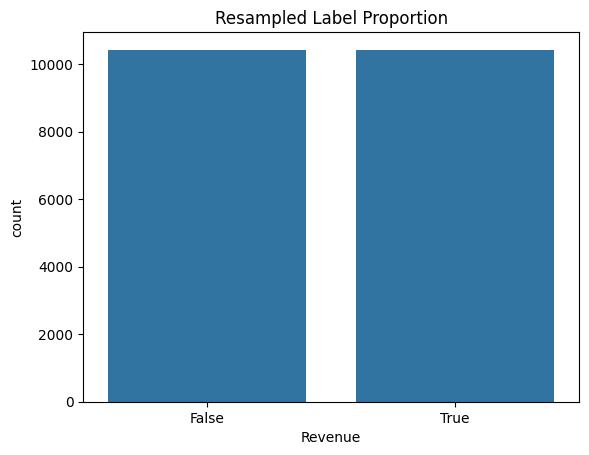

In [12]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Visualize resampled label proportion
sns.countplot(x=y_resampled)
plt.title("Resampled Label Proportion")
plt.show()

In [13]:
# Setup CatBoost and hyperparameters grid
catboost = CatBoostClassifier(verbose=0, random_state=42)
param_grid = {
    'iterations': [100, 200],
    'depth': [6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5]
}

# Setup GridSearchCV
kf = KFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=catboost, param_grid=param_grid, scoring='f1', cv=kf, verbose=1, n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x7a3d9c48f4c0>,
             n_jobs=-1,
             param_grid={'depth': [6, 10], 'iterations': [100, 200],
                         'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.01, 0.1, 0.2]},
             scoring='f1', verbose=1)

In [14]:
# Display best parameters
print("Best parameters found: ", grid_search.best_params_)
best_catboost = grid_search.best_estimator_

Best parameters found:  {'depth': 10, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.2}



Confusion Matrix:
[[1915  147]
 [  92 2015]]


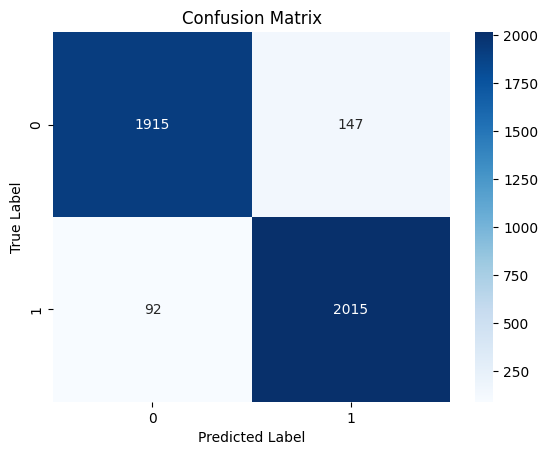

In [15]:
# Train and evaluate the model
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
best_catboost.fit(X_train, y_train)
y_pred = best_catboost.predict(X_test)

# Confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [16]:
# Classification report and accuracy/F1 score
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display results in a DataFrame
results = pd.DataFrame({
    'Model': ['CatBoost'],
    'Accuracy': [accuracy],
    'F1 Score': [f1]
})
print("\nAccuracy and F1 Score table:")
print(results)


Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.93      0.94      2062
        True       0.93      0.96      0.94      2107

    accuracy                           0.94      4169
   macro avg       0.94      0.94      0.94      4169
weighted avg       0.94      0.94      0.94      4169


Accuracy and F1 Score table:
      Model  Accuracy  F1 Score
0  CatBoost  0.942672  0.944015
